In [1]:
import argparse
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import optax
import tensorflow as tf
import tensorflow_probability as tfp
from chainconsumer import ChainConsumer
from haiku._src.nets.resnet import ResNet18
from jax.lib import xla_bridge
from config import Porqueres_2023
from jax_lensing.model import make_full_field_model
from numpyro import distributions as dist
from numpyro.handlers import condition, seed, trace
from sbi_lens.normflow.models import AffineCoupling, ConditionalRealNVP
from sbi_lens.normflow.train_model import TrainModel
from tqdm import tqdm

print(xla_bridge.get_backend().platform)

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
    
import psutil
# Get CPU memory usage
cpu_memory_usage = psutil.virtual_memory().percent
print("CPU Memory Usage:", cpu_memory_usage, "%")

import GPUtil
# Get available GPUs
gpus = GPUtil.getGPUs()
for gpu in gpus:
    memory_usage_percentage = (gpu.memoryUsed / gpu.memoryTotal) * 100
    print(f"GPU ID: {gpu.id}, GPU Name: {gpu.name}, GPU Memory Usage: {memory_usage_percentage:.2f}%")

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpu
CPU Memory Usage: 23.0 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 0.95%


### LPT Model

In [2]:
print("######## LPT MODEL ########")
# setting
fiducial_cosmology = Porqueres_2023.fiducial_cosmology
box_size = Porqueres_2023.box_size
box_shape = Porqueres_2023.box_shape
field_size = Porqueres_2023.field_size
field_npix = Porqueres_2023.field_npix
nz_shear = Porqueres_2023.nz_shear
sigma_e = Porqueres_2023.sigma_e
priors = Porqueres_2023.priors
nb_bins = nbins = len(nz_shear)
dim = len(priors)

lensing_model = jax.jit(
    make_full_field_model(
        field_size=field_size,
        field_npix=field_npix,
        box_size=box_size,
        box_shape=box_shape,
    )
)


# Define the probabilistic model
def model():
    """
    This function defines the top-level forward model for our observations
    """
    # Sampling initial conditions
    initial_conditions = numpyro.sample(
        "initial_conditions", dist.Normal(jnp.zeros(box_shape), jnp.ones(box_shape))
    )

    Omega_b = fiducial_cosmology.Omega_b
    h = fiducial_cosmology.h
    n_s = fiducial_cosmology.n_s
    w0 = fiducial_cosmology.w0
    Omega_c = numpyro.sample("Omega_c", priors["Omega_c"])
    sigma8 = numpyro.sample("sigma8", priors["sigma8"])

    cosmo = jc.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        sigma8=sigma8,
        h=h,
        n_s=n_s,
        w0=w0,
        wa=0.0,
        Omega_k=0.0,
    )

    # Generate random convergence maps
    convergence_maps, _ = lensing_model(cosmo, nz_shear, initial_conditions)

    # Apply noise to the maps (this defines the likelihood)
    observed_maps = [
        numpyro.sample(
            "kappa_%d" % i,
            dist.Normal(
                k,
                sigma_e
                / jnp.sqrt(
                    nz_shear[i].gals_per_arcmin2 * (field_size * 60 / field_npix) ** 2
                ),
            ),
        )
        for i, k in enumerate(convergence_maps)
    ]

    return observed_maps

######## LPT MODEL ########


### Fiducial Model

In [3]:
print("######### FIDUCIAL MODEL ##########")
# condition the model on a given set of parameters
fiducial_model = condition(
    model, {"Omega_c": fiducial_cosmology.Omega_c, "sigma8": fiducial_cosmology.sigma8}
)

# sample a mass map and save corresponding true parameters
model_trace = trace(seed(fiducial_model, jax.random.PRNGKey(1234))).get_trace()

m_data = jnp.stack([model_trace["kappa_%d" % i]["value"] for i in range(4)], axis=-1)

truth = [fiducial_cosmology.Omega_c, fiducial_cosmology.sigma8]

del model_trace

######### FIDUCIAL MODEL ##########


/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/linkhome/rech/genkqu01/uf

### Compressing Data

In [4]:
print("######## DATA GENERATION ########")

@jax.jit
@jax.vmap
def get_data(key):
    seeded_model = numpyro.handlers.seed(model, key)
    model_trace = numpyro.handlers.trace(seeded_model).get_trace()
    kmap = jnp.stack(
        [
            model_trace["kappa_0"]["value"],
            model_trace["kappa_1"]["value"],
            model_trace["kappa_2"]["value"],
            model_trace["kappa_3"]["value"],
        ],
        axis=-1,
    ).astype("float32")
    theta = jnp.stack([model_trace["Omega_c"]["value"], model_trace["sigma8"]["value"]])

    return theta, kmap


# training dataset
params_train = []
maps_train = []
masterkey = jax.random.PRNGKey(42)
bs = 45

for i in tqdm(range(5_000)):
    key, masterkey = jax.random.split(masterkey)
    params, kmap = get_data(jax.random.split(key, bs))
    params_train.append(params)
    maps_train.append(kmap)

params_train = np.stack(params_train).reshape([-1, 2])
maps_train = np.stack(maps_train).reshape([-1, field_npix, field_npix, nbins])
dataset_train = {"theta": params_train, "maps": maps_train}

del maps_train, params_train

# test dataset
params_test = []
maps_test = []
masterkey = jax.random.PRNGKey(20)
bs = 40

for i in tqdm(range(20)):
    key, masterkey = jax.random.split(masterkey)
    params, kmap = get_data(jax.random.split(key, bs))
    params_test.append(params)
    maps_test.append(kmap)

params_test = np.stack(params_test).reshape([-1, 2])
maps_test = np.stack(maps_test).reshape([-1, field_npix, field_npix, nbins])
dataset_test = {"theta": params_test, "maps": maps_test}

del maps_test, params_test

######## DATA GENERATION ########


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


In [5]:
print("######## CREATE COMPRESSOR ########")
# nf
bijector_layers_compressor = [128] * 6

bijector_compressor = partial(
    AffineCoupling, layers=bijector_layers_compressor, activation=jax.nn.silu
)

NF_compressor = partial(ConditionalRealNVP, n_layers=4, bijector_fn=bijector_compressor)


class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(dim)(y)
        return nvp


nf = hk.without_apply_rng(
    hk.transform(lambda theta, y: Flow_nd_Compressor()(y).log_prob(theta).squeeze())
)

# compressor
class CompressorCNN2D(hk.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim

    def __call__(self, x):
        net_x = hk.Conv2D(32, 3, 2)(x) 
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Conv2D(64, 3, 2)(net_x) 
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.Conv2D(128, 3, 2)(net_x)
        net_x = jax.nn.leaky_relu(net_x)
        net_x = hk.AvgPool(16,8,'SAME')(net_x) 
        net_x = hk.Flatten()(net_x)

        net_x = hk.Linear(2)(net_x)
        
        return net_x.squeeze()
    
compressor = hk.transform_with_state(lambda y: CompressorCNN2D(dim)(y))
compressor_eval = hk.transform_with_state(lambda y: CompressorCNN2D(dim)(y))

######## CREATE COMPRESSOR ########


In [6]:
print("######## TRAIN ########")

# init compressor
parameters_resnet, opt_state_resnet = compressor.init(
    jax.random.PRNGKey(0), y=0.5 * jnp.ones([1, field_npix, field_npix, nbins])
)
# init nf
params_nf = nf.init(
    jax.random.PRNGKey(0), theta=0.5 * jnp.ones([1, dim]), y=0.5 * jnp.ones([1, dim])
)

parameters_compressor = hk.data_structures.merge(parameters_resnet, params_nf)

del parameters_resnet, params_nf

# define optimizer
total_steps = 100_000
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={
        int(total_steps * 0.1): 0.7,
        int(total_steps * 0.2): 0.7,
        int(total_steps * 0.3): 0.7,
        int(total_steps * 0.4): 0.7,
        int(total_steps * 0.5): 0.7,
        int(total_steps * 0.6): 0.7,
        int(total_steps * 0.7): 0.7,
        int(total_steps * 0.8): 0.7,
        int(total_steps * 0.9): 0.7,
    },
)

optimizer_c = optax.adam(learning_rate=lr_scheduler)
opt_state_c = optimizer_c.init(parameters_compressor)

model_compressor = TrainModel(
    compressor=compressor,
    nf=nf,
    optimizer=optimizer_c,
    loss_name="train_compressor_vmim",
)

update = jax.jit(model_compressor.update)

batch_size = 128
masterkey =jax.random.PRNGKey(0)
store_loss = []
loss_train = []
loss_test = []
for batch in tqdm(range(total_steps)):
    key,masterkey = jax.random.split(masterkey)
    inds = np.random.randint(0, len(dataset_train["theta"]), batch_size)
    if not jnp.isnan(dataset_train["theta"][inds]).any():
        b_loss, parameters_compressor, opt_state_c, opt_state_resnet = update(
            model_params=parameters_compressor,
            opt_state=opt_state_c,
            theta=dataset_train["theta"][inds],
            x=dataset_train["maps"][inds], 
            state_resnet=opt_state_resnet,
        )

        store_loss.append(b_loss)

        if jnp.isnan(b_loss):
            print("NaN Loss")
            break
            
    if batch % 3_000 == 0:

        # Get CPU memory usage
        cpu_memory_usage = psutil.virtual_memory().percent
        print("CPU Memory Usage:", cpu_memory_usage, "%")
        # Get available GPUs
        gpus = GPUtil.getGPUs()
        for gpu in gpus:
            memory_usage_percentage = (gpu.memoryUsed / gpu.memoryTotal) * 100
            print(f"GPU ID: {gpu.id}, GPU Name: {gpu.name}, GPU Memory Usage: {memory_usage_percentage:.2f}%")

        # save params
        with open(f"./save_params/params_nd_compressor_batch{batch}.pkl", "wb") as fp:
            pickle.dump(parameters_compressor, fp)

        with open(f"./save_params/opt_state_resnet_batch{batch}.pkl", "wb") as fp:
            pickle.dump(opt_state_resnet, fp)


        inds2 = np.random.randint(0, len(dataset_test["theta"]), batch_size)
        key,masterkey = jax.random.split(masterkey)
        b_loss_test, _, _, _ = update(
            model_params=parameters_compressor,
            opt_state=opt_state_c,
            theta=dataset_test["theta"][inds2],
            x=dataset_test["maps"][inds2], 
            state_resnet=opt_state_resnet,
        )

        loss_train.append(b_loss)
        loss_test.append(b_loss_test)

        jnp.save("./save_params/loss_train.npy", loss_train)
        jnp.save("./save_params/loss_test.npy", loss_test)


with open(f"./save_params/params_nd_compressor_batch{batch}.pkl", "wb") as fp:
    pickle.dump(parameters_compressor, fp)

with open(f"./save_params/opt_state_resnet_batch{batch}.pkl", "wb") as fp:
    pickle.dump(opt_state_resnet, fp)

######## TRAIN ########


  0%|          | 1/100000 [00:08<243:43:16,  8.77s/it]

CPU Memory Usage: 39.4 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


  3%|▎         | 3003/100000 [00:31<15:58, 101.20it/s]

CPU Memory Usage: 39.4 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


  6%|▌         | 6006/100000 [00:55<14:38, 106.93it/s]

CPU Memory Usage: 39.5 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


  9%|▉         | 9002/100000 [01:18<14:53, 101.86it/s]

CPU Memory Usage: 39.5 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 12%|█▏        | 12012/100000 [01:41<14:10, 103.48it/s]

CPU Memory Usage: 39.5 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 15%|█▌        | 15005/100000 [02:04<14:03, 100.75it/s]

CPU Memory Usage: 39.5 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 18%|█▊        | 18014/100000 [02:27<12:01, 113.63it/s]

CPU Memory Usage: 39.5 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 21%|██        | 21010/100000 [02:50<11:59, 109.80it/s]

CPU Memory Usage: 39.6 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 24%|██▍       | 24006/100000 [03:13<11:57, 105.94it/s]

CPU Memory Usage: 39.6 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 27%|██▋       | 27002/100000 [03:35<11:29, 105.82it/s]

CPU Memory Usage: 39.6 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 30%|███       | 30012/100000 [03:58<10:58, 106.30it/s]

CPU Memory Usage: 39.6 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 33%|███▎      | 33008/100000 [04:21<10:41, 104.47it/s]

CPU Memory Usage: 39.6 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 36%|███▌      | 36018/100000 [04:44<09:02, 117.86it/s]

CPU Memory Usage: 39.6 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 39%|███▉      | 39014/100000 [05:07<09:08, 111.23it/s]

CPU Memory Usage: 39.7 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 42%|████▏     | 42008/100000 [05:30<08:46, 110.13it/s]

CPU Memory Usage: 39.7 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 45%|████▌     | 45004/100000 [05:53<08:26, 108.67it/s]

CPU Memory Usage: 39.7 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 48%|████▊     | 48014/100000 [06:16<08:05, 107.05it/s]

CPU Memory Usage: 39.7 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 51%|█████     | 51010/100000 [06:39<07:32, 108.16it/s]

CPU Memory Usage: 39.7 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 54%|█████▍    | 54006/100000 [07:01<07:06, 107.80it/s]

CPU Memory Usage: 39.8 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 57%|█████▋    | 57016/100000 [07:24<06:12, 115.40it/s]

CPU Memory Usage: 39.8 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 60%|██████    | 60012/100000 [07:47<06:13, 107.21it/s]

CPU Memory Usage: 37.8 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 63%|██████▎   | 63008/100000 [08:10<05:28, 112.66it/s]

CPU Memory Usage: 37.8 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 66%|██████▌   | 66004/100000 [08:33<05:12, 108.70it/s]

CPU Memory Usage: 37.8 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 69%|██████▉   | 69014/100000 [08:56<04:42, 109.76it/s]

CPU Memory Usage: 37.8 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 72%|███████▏  | 72010/100000 [09:19<04:12, 111.00it/s]

CPU Memory Usage: 37.4 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 75%|███████▌  | 75006/100000 [09:41<03:58, 104.94it/s]

CPU Memory Usage: 37.6 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 78%|███████▊  | 78002/100000 [10:04<03:28, 105.74it/s]

CPU Memory Usage: 37.7 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 81%|████████  | 80998/100000 [10:27<02:24, 131.52it/s]

CPU Memory Usage: 39.4 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 84%|████████▍ | 84008/100000 [10:49<02:26, 108.93it/s]

CPU Memory Usage: 40.1 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 87%|████████▋ | 87018/100000 [11:12<01:50, 117.89it/s]

CPU Memory Usage: 40.3 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 90%|█████████ | 90014/100000 [11:35<01:28, 113.12it/s]

CPU Memory Usage: 40.5 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 93%|█████████▎| 93010/100000 [11:57<01:09, 100.53it/s]

CPU Memory Usage: 40.7 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 96%|█████████▌| 96006/100000 [12:20<00:36, 110.42it/s]

CPU Memory Usage: 38.6 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


 99%|█████████▉| 99016/100000 [12:43<00:08, 113.81it/s]

CPU Memory Usage: 37.6 %
GPU ID: 0, GPU Name: Tesla V100-SXM2-32GB, GPU Memory Usage: 92.08%


100%|██████████| 100000/100000 [12:50<00:00, 129.80it/s]


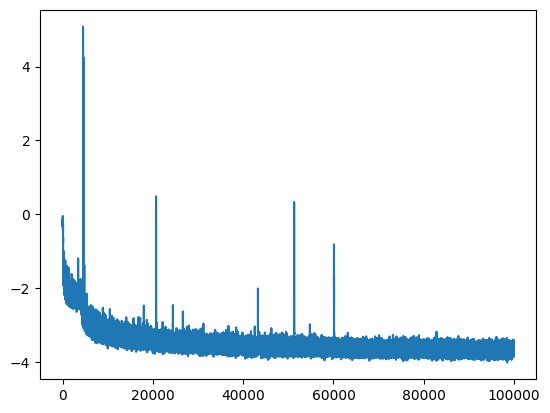

In [7]:
plt.plot(store_loss[100:])

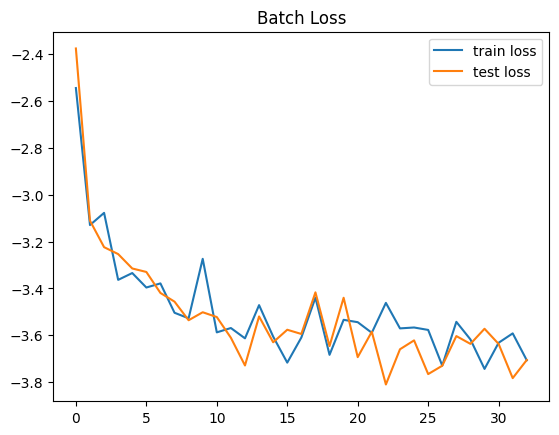

In [8]:
plt.figure()
plt.plot(loss_train[1:], label="train loss")
plt.plot(loss_test[1:], label="test loss")
plt.legend()
plt.title("Batch Loss")
plt.savefig("./fig/loss_compressor_train_test")

<Figure size 640x480 with 0 Axes>

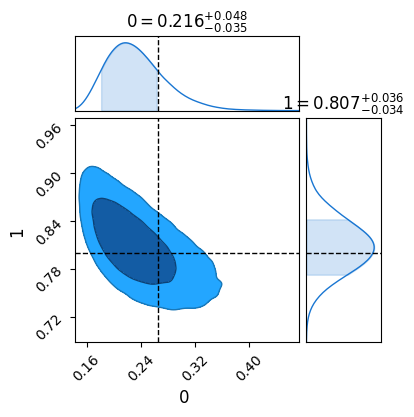

In [9]:
y, _ = compressor_eval.apply(
    parameters_compressor,
    opt_state_resnet,
    None,
    m_data.reshape([1, field_npix, field_npix, nbins]),
)

nvp_sample_nd = hk.transform(
    lambda x: Flow_nd_Compressor()(x).sample(100000, seed=hk.next_rng_key())
)
sample_nd = nvp_sample_nd.apply(
    parameters_compressor,
    rng=jax.random.PRNGKey(43),
    x=y * jnp.ones([100000, dim]),
)
idx = jnp.where(jnp.isnan(sample_nd))[0]
sample_nd = jnp.delete(sample_nd, idx, axis=0)

plt.figure()
c = ChainConsumer()
c.add_chain(sample_nd, name="SBI")
fig = c.plotter.plot(figsize=1.2, truth=truth)

plt.savefig(f"./fig/contour_plot_compressor_batch{batch}")

### Inference

In [ ]:
@jax.jit
@jax.vmap
def get_data(key):
    seeded_model = numpyro.handlers.seed(model, key)
    model_trace = numpyro.handlers.trace(seeded_model).get_trace()
    kmap = jnp.stack(
        [
            model_trace["kappa_0"]["value"],
            model_trace["kappa_1"]["value"],
            model_trace["kappa_2"]["value"],
            model_trace["kappa_3"]["value"],
        ],
        axis=-1,
    ).astype("float32")
    theta = jnp.stack([model_trace["Omega_c"]["value"], model_trace["sigma8"]["value"]])

    return theta, kmap

In [11]:
print("######## COMPRESS DATA ########")

# test dataset
params_train = []
maps_train = []
masterkey = jax.random.PRNGKey(2988)
bs = 45

for i in tqdm(range(1_000)):
    key, masterkey = jax.random.split(masterkey)
    params, kmap = get_data(jax.random.split(key, bs))
    params_train.append(params)
    maps_train.append(kmap)

params_train = np.stack(params_train).reshape([-1, 2])
maps_train = np.stack(maps_train).reshape([-1, field_npix, field_npix, nbins])
dataset_train = {"theta": params_train, "maps": maps_train}

del params_train, maps_train


data_compressed, _ = compressor_eval.apply(
    parameters_compressor, 
    opt_state_resnet, 
    None, 
    dataset_train['maps'].reshape([-1,field_npix, field_npix, nbins])
)

train_dataset_compressed = {'theta':dataset_train['theta'], 'x':data_compressed}

del dataset_train

#######################################################

# test dataset
params_test = []
maps_test = []
masterkey = jax.random.PRNGKey(53542)
bs = 43

for i in tqdm(range(40)):
    key, masterkey = jax.random.split(masterkey)
    params, kmap = get_data(jax.random.split(key, bs))
    params_test.append(params)
    maps_test.append(kmap)

params_test = np.stack(params_test).reshape([-1, 2])
maps_test = np.stack(maps_test).reshape([-1, field_npix, field_npix, nbins])
dataset_test = {"theta": params_test, "maps": maps_test}

del params_test, maps_test



data_compressed, _ = compressor_eval.apply(
    parameters_compressor, 
    opt_state_resnet, 
    None, 
    dataset_test['maps'].reshape([-1,field_npix, field_npix, nbins])
)
test_dataset_compressed = {'theta':dataset_test['theta'], 'x':data_compressed}

######## COMPRESS DATA ########


  0%|          | 0/1000 [00:00<?, ?it/s]/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] -

In [24]:
print("######## CREATE NDE ########")
# Create neural density estimator (NDE) to approximate p(theta | y)

summary_stat_dim = 2
nb_params_to_infer = 2
batch_size = 128


# Affine bijection used in the RealNVP coupling
bijector_ff = partial(
  AffineCoupling,
  layers=[128] * 2,
  activation=jax.nn.silu
)

# Normalizing Flow with 4 RealNVP coupling layers
NF_ff = partial(
  ConditionalRealNVP,
  n_layers=4,
  bijector_fn=bijector_ff
)


# log probability of the NDE
nf_logp_ff = hk.without_apply_rng(
    hk.transform(
        lambda theta,y : NF_ff(nb_params_to_infer)(y).log_prob(theta).squeeze()
    )
)

# sampling of the NDE
nf_sample_ff = hk.transform(
  lambda y : NF_ff(nb_params_to_infer)(y).sample(100_000, seed=hk.next_rng_key())
)

######## CREATE NDE ########


In [25]:
print("######## UTILS FUN ########")

# negative log likelihood
def loss_nll(params, mu, batch):
    return - jnp.mean(nf_logp_ff.apply(params, mu, batch))

@jax.jit
def update(params, opt_state, mu, batch):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_nll)(
        params,
        mu,
        batch,
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

######## UTILS FUN ########


######## TRAINING ########


loss -3.566: 100%|██████████| 30000/30000 [01:50<00:00, 272.22it/s]


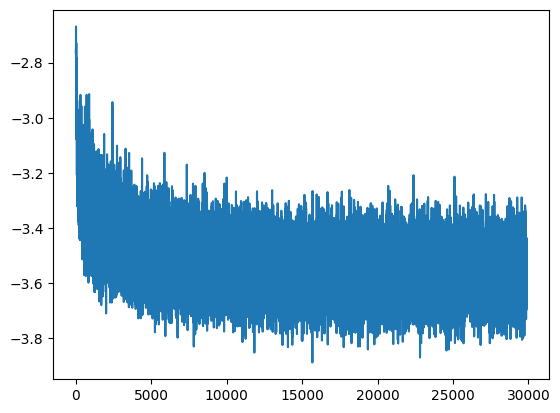

In [26]:
print("######## TRAINING ########")
# init nf params
params_ff = nf_logp_ff.init(
    jax.random.PRNGKey(42),
    0.5 * jnp.zeros([1, summary_stat_dim]),
    0.5 * jnp.zeros([1, nb_params_to_infer])
)

total_steps = 30_000
nb_steps = total_steps - total_steps * 0.2

lr_scheduler = optax.exponential_decay(
        init_value=1e-3,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-6,
)

# define optimizer
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state_ff = optimizer.init(params_ff)


# training
from tqdm import tqdm

batch_size = 128
batch_loss = []
loss_train = []
loss_test=[]
pbar = tqdm(range(total_steps))

for batch in pbar:
    inds = np.random.randint(0, len(test_dataset_compressed['theta']), batch_size)

    l, params_ff, opt_state_ff = update(
      params_ff,
      opt_state_ff,
      train_dataset_compressed['theta'][inds],
      train_dataset_compressed['x'][inds],
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")
    
    
    if batch % 1_000 == 0:

        # save params
        with open(f"./save_params/params_nd_flow_batch{batch}.pkl", "wb") as fp:
            pickle.dump(params_ff, fp)


        inds2 = np.random.randint(0, len(dataset_test["theta"]), batch_size)
        b_loss_test, _, _ = update(
          params_ff,
          opt_state_ff,
          test_dataset_compressed["theta"][inds2],
          test_dataset_compressed['x'][inds2],
        )
        

        loss_train.append(l)
        loss_test.append(b_loss_test)

        
plt.plot(batch_loss[100:])

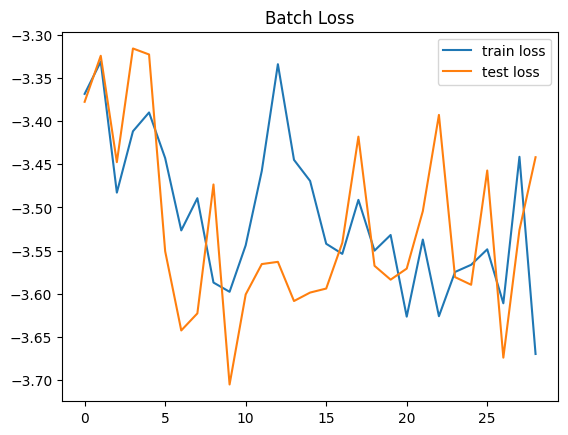

In [27]:
plt.figure()
plt.plot(loss_train[1:], label="train loss")
plt.plot(loss_test[1:], label="test loss")
plt.legend()
plt.title("Batch Loss")
plt.savefig("./fig/loss_compressor_train_test")

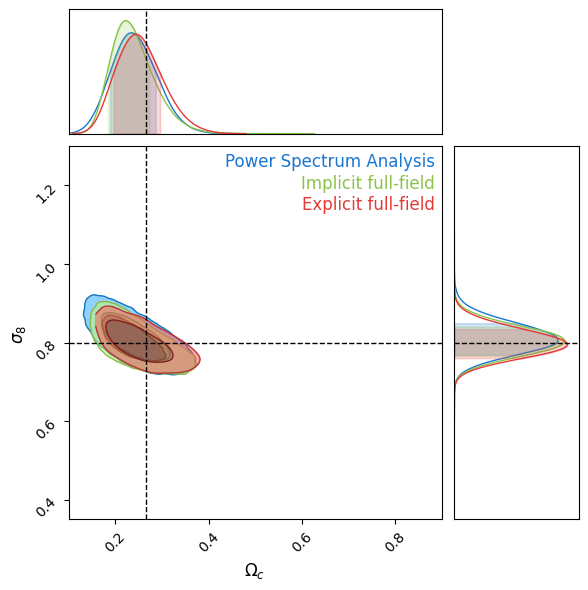

In [34]:
LPTPorqueres2023_full_field_hmc = jnp.load('LPTPorqueres2023_full_field_hmc.npy')
LPTPorqueres2023_ps = jnp.load('LPTPorqueres2023_powerspectrum_analysis.npy')

from chainconsumer import ChainConsumer

observed_map_compressed, _ = compressor_eval.apply(
    parameters_compressor,
    opt_state_resnet,
    None,
    m_data.reshape([1,field_npix,field_npix,nbins])
)


posterior_ff = nf_sample_ff.apply(
      params_ff,
      rng = jax.random.PRNGKey(70),
      y = observed_map_compressed * jnp.ones([100_000, summary_stat_dim])
)


c = ChainConsumer()


c.add_chain(
    LPTPorqueres2023_ps,
    shade_alpha = 0.5,
    name='Power Spectrum Analysis',
    parameters=['$\Omega_c$','$\sigma_8$'],
)

c.add_chain(
    posterior_ff,
    shade_alpha = 0.5,
    name='Implicit full-field',
    parameters=['$\Omega_c$','$\sigma_8$'],
)

c.add_chain(
    LPTPorqueres2023_full_field_hmc,
    shade_alpha = 0.5,
    name='Explicit full-field',
    parameters=['$\Omega_c$','$\sigma_8$'],
    kde=2
)


fig = c.plotter.plot(figsize=2.,truth=[fiducial_cosmology.Omega_c, fiducial_cosmology.sigma8], extents={"$\Omega_c$": (0.1,0.9), "$\sigma_8$": (0.35,1.3)})

plt.savefig('LPTPorqueres2023_results')

In [32]:
jnp.save('LPTPorqueres2023_implicit_full_field.npy', posterior_ff)